# Aeroelastic Analysis of a Highly Flexible Wing

In this example, we demonstrate how to perform a three-dimensional aeroelastic analysis
of a highly flexible cantilever wing.

![](../assets/cantilever-wing.png)

The wing we are considering in this example was created by modifying Daedalus aircraft
data and is therefore representative of a high-altitude long-endurance wing. It has a
16 meter span (from root to tip) and a 1 meter chord. To model the wing's aerodynamics,
we use a lifting line model. To model the wing's structure, we use a geometrically exact
beam theory model.

In [1]:
using Aeroelasticity, GXBeam, DifferentialEquations, LinearAlgebra

# --- Initial Setup --- #

# discretization
N = 8 # number of elements

# geometric properties
span = 16 # m
chord = 1 # m
xref = 0.5 # normalized reference location (from leading edge)
xcg = 0.5 # center of gravity (from leading edge)

# stiffness properties
GJ = 1e4 # N*m^2 (torsional rigidity)
EIyy = 2e4 # N*m^2 (flat bending rigidity)
EIzz = 4e6 # N*m^2 (chord bending rigidity)

4.0e6

inertial properties

In [2]:
mu = 0.75 # kg/m (mass per unit length)
i11 = 0.1 # kg*m (moment of inertia about elastic axis)
i22 = 0.0375 # moment of inertia about beam y-axis
i33 = 0.0625 # moment of inertia about beam z-axis

# freestream properties
Vinf = 10.0 # m/s (velocity)
rho = 0.0889 # kg/m^3 (air density at 20 km)
c = 343 # m/s (air speed of sound)
alpha = 2*pi/180 # angle of attack

# aerodynamic section properties
a = xref - 0.5 # normalized reference location (relative to semi-chord)
b = chord / 2 # m (semi-chord)
a0 = 2*pi # lift slope (for each section)
alpha0 = 0 # zero lift angle of attack (for each section)
cd0 = 0
cm0 = 0

# define geometry (assume NED coordinate frame)
xpt = range(0, 0, length=N+1) # point x-coordinates (in body frame)
ypt = range(0, span, length=N+1) # point y-coordinates (in body frame)
zpt = range(0, 0, length=N+1) # point z-coordinates (in body frame)
points = [[xpt[i],ypt[i],zpt[i]] for i = 1:N+1]
start = 1:N # starting point of each beam element
stop = 2:N+1 # ending point of each beam element
e1 = [0, 1,  0] # beam x-axis
e2 = [1, 0,  0] # beam y-axis
e3 = [0, 0, -1] # beam z-axis
frames = fill([e1 e2 e3], N) # local to body frame transformation
compliance = fill(Diagonal([0, 0, 0, 1/GJ, 1/EIyy, 1/EIzz]), N) # compliance matrix
mass = fill(Diagonal([mu, mu, mu, i11, i22, i33]), N) # mass matrix
damping = fill(fill(1e-4, 6), N) # stiffness proportional structural damping coefficients
assembly = GXBeam.Assembly(points, start, stop; frames, compliance, mass, damping)

prescribed_conditions = Dict(
    # fixed left edge
    1 => GXBeam.PrescribedConditions(ux=0, uy=0, uz=0, theta_x=0, theta_y=0, theta_z=0),
)

# define GXBeam system
system = DynamicSystem(assembly)

# --- Define Submodels --- #

# construct section models
section_models = fill(Peters{6}(), N)

# construct aerodynamic model
aerodynamic_model = LiftingLine(section_models)

# construct structural model
structural_model = GXBeamAssembly(system; structural_damping=true)

# define submodels
submodels = (aerodynamic_model, structural_model)

(LiftingLine{Vector{Peters{6, Float64, StaticArraysCore.SVector{6, Float64}, StaticArraysCore.SMatrix{6, 6, Float64, 36}}}, Vector{Aeroelasticity.PetersLiftingLine{6, Float64, StaticArraysCore.SVector{6, Float64}, StaticArraysCore.SMatrix{6, 6, Float64, 36}}}, Vector{UnitRange{Int64}}}(Peters{6, Float64, StaticArraysCore.SVector{6, Float64}, StaticArraysCore.SMatrix{6, 6, Float64, 36}}[Peters{6, Float64, StaticArraysCore.SVector{6, Float64}, StaticArraysCore.SMatrix{6, 6, Float64, 36}}([46.0 -315.5 … 378.0 -1.5; 15.75 -105.0 … 126.0 -0.5; … ; 6.2 -42.0 … 50.400000000000006 -0.30000000000000004; 5.166666666666667 -35.0 … 42.083333333333336 -0.16666666666666666], [30.0, -210.0, 560.0, -630.0, 252.0, -1.0], [2.0, 1.0, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333]), Peters{6, Float64, StaticArraysCore.SVector{6, Float64}, StaticArraysCore.SMatrix{6, 6, Float64, 36}}([46.0 -315.5 … 378.0 -1.5; 15.75 -105.0 … 126.0 -0.5; … ; 6.2 -42.0 … 50.400000000000006 -0.30000000000000004; 5.16666666

--- Define Initial Parameters --- #

In [3]:
V = [-Vinf*cos(alpha), 0.0, -Vinf*sin(alpha)] # m/s (freestream velocity)

# define parameters for each lifting line section
section_parameters = fill([a, b, a0, alpha0, cd0, cm0], N)

# define parameters for the lifting line model
liftingline_parameters = LiftingLineParameters(section_parameters)

# define parameters for the geometrically exact beam theory model
gxbeam_parameters = GXBeamParameters(assembly)

GXBeam.Assembly{Float64, Vector{StaticArraysCore.SVector{3, Float64}}, UnitRange{Int64}, Vector{GXBeam.Element{Float64}}}(StaticArraysCore.SVector{3, Float64}[[0.0, 0.0, 0.0], [0.0, 2.0, 0.0], [0.0, 4.0, 0.0], [0.0, 6.0, 0.0], [0.0, 8.0, 0.0], [0.0, 10.0, 0.0], [0.0, 12.0, 0.0], [0.0, 14.0, 0.0], [0.0, 16.0, 0.0]], 1:8, 2:9, GXBeam.Element{Float64}[GXBeam.Element{Float64}(2.0, [0.0, 1.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 5.0e-5 0.0; 0.0 0.0 … 0.0 2.5e-7], [0.75 0.0 … 0.0 0.0; 0.0 0.75 … 0.0 0.0; … ; 0.0 0.0 … 0.0375 0.0; 0.0 0.0 … 0.0 0.0625], [0.0 1.0 0.0; 1.0 0.0 0.0; 0.0 0.0 -1.0], [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]), GXBeam.Element{Float64}(2.0, [0.0, 3.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 5.0e-5 0.0; 0.0 0.0 … 0.0 2.5e-7], [0.75 0.0 … 0.0 0.0; 0.0 0.75 … 0.0 0.0; … ; 0.0 0.0 … 0.0375 0.0; 0.0 0.0 … 0.0 0.0625], [0.0 1.0 0.0; 1.0 0.0 0.0; 0.0 0.0 -1.0], [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]), GXBeam.Element{

define parameters for the coupling

In [4]:
coupling_parameters = LiftingLineGXBeamParameters(V, rho, c;
    prescribed_conditions = prescribed_conditions,
    gravity = [-9.81*sin(alpha), 0, 9.81*cos(alpha)])

# combine parameters
parameters = (liftingline_parameters, gxbeam_parameters, coupling_parameters)

# --- Define Coupled Model --- #

model = CoupledModel(submodels, parameters; symbolic=false)

# --- Perform Analysis --- #

# loop through freestream velocities
Vinf = vcat(0.1, 0.25:0.25:50)

# eigenvalue/eigenvector storage
nev = 12*N
λ = zeros(ComplexF64, nev, length(Vinf))
Uλ = zeros(ComplexF64, nev, number_of_states(model), length(Vinf))
Vλ = zeros(ComplexF64, number_of_states(model), nev, length(Vinf))

# initial guess for state variables
x0 = zeros(number_of_states(model))

# loop through each velocity
for i = 1:length(Vinf)

    # --- Update Parameters --- #

    V = [-Vinf[i]*cos(alpha), 0.0, -Vinf[i]*sin(alpha)] # m/s (freestream velocity)

    # define parameters for each lifting line section
    section_parameters = fill([a, b, a0, alpha0, cd0, cm0], N)

    # define parameters for the lifting line model
    liftingline_parameters = LiftingLineParameters(section_parameters)

    # define parameters for the geometrically exact beam theory model
    gxbeam_parameters = GXBeamParameters(assembly)

    # define parameters for the coupling
    coupling_parameters = LiftingLineGXBeamParameters(V, rho, c;
        prescribed_conditions = prescribed_conditions,
        gravity = [-9.81*sin(alpha), 0, 9.81*cos(alpha)])

    # combine parameters
    parameters = (liftingline_parameters, gxbeam_parameters, coupling_parameters)

    # --- Perform Analysis --- #

    # define an ODEFunction for this model
    f = ODEFunction(model, parameters)

    # find equilibrium point
    sol = solve(NonlinearProblem(SteadyStateProblem(f, x0, parameters)))

    # use state variables from steady state operating conditions
    x = sol.u

    # linearize about steady state operating conditions
    K, M = linearize(model, x, parameters)

    # perform linear stability analysis
    λi, Uλi, Vλi = sparse_eigen(K, M; nev=nev)

    # --- Correlate Eigenvalues --- #

    if i > 1
        # previous left eigenvector matrix
        Uλpi = Uλ[:,:,i-1]

        # use correlation matrix to correlate eigenmodes
        perm, corruption = Aeroelasticity.correlate_eigenmodes(Uλpi, M, Vλi)

        # re-arrange eigenmodes
        λi = λi[perm]
        Uλi = Uλi[perm,:]
        Vλi = Vλi[:,perm]
    end

    # save eigenvalues/eigenvectors
    λ[:,i] = λi
    Uλ[:,:,i] = Uλi
    Vλ[:,:,i] = Vλi

    # update initial guess for the state variables
    x0 .= x
end

┌ Warning: Assignment to `V` in soft scope is ambiguous because a global variable by the same name exists: `V` will be treated as a new local. Disambiguate by using `local V` to suppress this warning or `global V` to assign to the existing global variable.
└ @ ~/work/Aeroelasticity.jl/Aeroelasticity.jl/docs/src/examples/cantilever-stability.ipynb:31
┌ Warning: Assignment to `section_parameters` in soft scope is ambiguous because a global variable by the same name exists: `section_parameters` will be treated as a new local. Disambiguate by using `local section_parameters` to suppress this warning or `global section_parameters` to assign to the existing global variable.
└ @ ~/work/Aeroelasticity.jl/Aeroelasticity.jl/docs/src/examples/cantilever-stability.ipynb:34
┌ Warning: Assignment to `liftingline_parameters` in soft scope is ambiguous because a global variable by the same name exists: `liftingline_parameters` will be treated as a new local. Disambiguate by using `local liftingline_pa

To identify the flutter speed and frequency, we can plot the results.

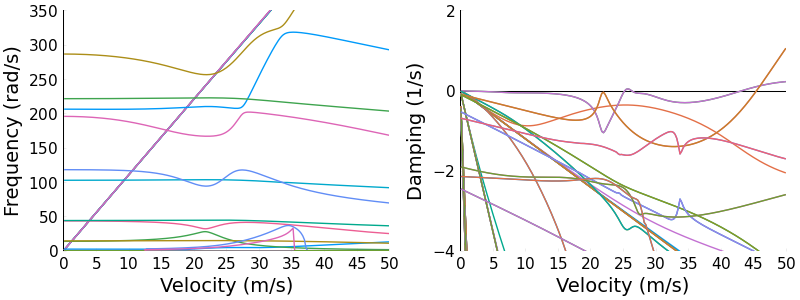

In [5]:
using Plots
pyplot()

sp1 = plot(
    xlim = (0, 50),
    xtick = 0:5:50,
    xlabel = "Velocity (m/s)",
    ylim = (0, 350),
    ytick = 0:50:350,
    ylabel = "Frequency (rad/s)",
    framestyle = :zerolines,
    grid = false,
    titlefontsize = 14,
    guidefontsize = 14,
    legendfontsize = 11,
    tickfontsize = 11,
    legend = :topright,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    minorgrid=false)

sp2 = plot(
    xlim = (0, 50),
    xtick = 0:5:50,
    xlabel = "Velocity (m/s)",
    ylim = (-4, 2),
    ytick = -4:2:2,
    ylabel = "Damping (1/s)",
    framestyle = :zerolines,
    grid = false,
    titlefontsize = 14,
    guidefontsize = 14,
    legendfontsize = 11,
    tickfontsize = 11,
    legend = :topleft,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
    minorgrid=false)

for i = 1:size(λ, 1)

    Vi = Vinf[:]
    λi = λ[i,:]

    if any(abs.(λi) .<= 1e4)
        plot!(sp1, Vi, imag.(λi),
            label = "",
            color = i,
            markersize = 3,
            markerstrokewidth = 0,
            )
    end

end

for i = 1:size(λ, 1)

    Vi = Vinf[:]
    λi = λ[i,:]

    if any(abs.(λi) .<= 1e4)
        plot!(sp2, Vi,
            real.(λi),#./sqrt.(real.(λi).^2 + abs.(λi).^2)*100,
            label = "",
            color = i,
            markersize = 3,
            markerstrokewidth = 0,
            )
    end
end

p1 = plot(sp1, sp2, layout = (1, 2), size = (800, 300))

These results are similar to those presented by Patil, Hodges, and Cesnik in "Nonlinear
Aeroelasticity and Flight Dynamics of High Altitude Long-Endurance Aircraft" and
therefore serve as a verification case for this coupled model.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*